# Battle of Neighborhoods

# North York

## Comparing Neighborhoods of North York, Canada

### 1. Data Extraction

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
!pip install geopy
import json
import xml
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install folium
import folium 
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 92kB 11.5MB/s eta 0:00:01


In [3]:
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050."
source = requests.get(url).text
Canada_data = BeautifulSoup(source, 'lxml')

In [4]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)
content = Canada_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
                                 
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [5]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [6]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [8]:
print(df2.shape)
df2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [10]:
!pip install geocoder
import geocoder
def get_latlng(postal_code):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords
    
get_latlng('M4G')

     |████████████████████████████████| 102kB 7.5MB/s ta 0:00:011


[43.70941386000004, -79.36309957799995]

In [15]:
postal_codes = df['Postalcode']    
coords = [ get_latlng(postal_code) for postal_code in postal_codes.tolist() ]

In [16]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [19]:
df[df.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.656072,-79.385653


In [20]:
df.head(5)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.808626,-79.189913
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785779,-79.157368
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765806,-79.185284
3,M1G,Scarborough,Woburn,43.771545,-79.218135
4,M1H,Scarborough,Cedarbrae,43.768791,-79.238813


In [21]:
df.shape

(103, 5)

In [22]:
df = df[df['Borough'] == 'North York'].reset_index(drop=True)
df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M2H,North York,Hillcrest Village,43.802556,-79.356566
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.780306,-79.348687
2,M2K,North York,Bayview Village,43.780607,-79.376921
3,M2L,North York,"Silver Hills, York Mills",43.749360,-79.380690
4,M2M,North York,"Newtonbrook, Willowdale",43.791800,-79.406428


In [23]:
df.shape

(24, 5)

In [24]:
address = 'North York,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of Seattle,Washington are 43.7543263, -79.44911696639593.


### North York Canada

In [25]:
map_NorthYork = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# add markers to map
for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NorthYork)  
    
map_NorthYork

In [26]:
address = 'North York,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The geograpical coordinate of neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of neighborhood_1 are 43.7543263, -79.44911696639593.


In [28]:
CLIENT_ID = '4H0U3X0HTMGXJ1IMS2M1PISGPIQTCZQNKSXITOPAOKPEKFJR'
CLIENT_SECRET = 'V5NKPJ25TTUBN2ZZRFF0QUEC1DMMIRATP4JYIY4ITJZ1F3YS' 
VERSION = '20180605' 

In [29]:
import requests
radius = 900 
LIMIT = 150
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [30]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [31]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Exploring Neighborhood Venues

In [32]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(5)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Wolfie's Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",43.754875,-79.442438
2,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
3,Bagel Plus,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.755395,-79.440686
4,Le Montmartre,"[{'id': '4bf58dd8d48988d10c941735', 'name': 'F...",43.751219,-79.457446


### 5. Categories of Nearby Venues

In [33]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Wolfie's Deli,Deli / Bodega,43.754875,-79.442438
2,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
3,Bagel Plus,Restaurant,43.755395,-79.440686
4,Le Montmartre,French Restaurant,43.751219,-79.457446


In [34]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Coffee Shop                 4
Pizza Place                 3
Bank                        2
Gas Station                 2
Ice Cream Shop              1
Deli / Bodega               1
Mediterranean Restaurant    1
Convenience Store           1
Bus Line                    1
Sushi Restaurant            1
Name: categories, dtype: int64

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=700): 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
NorthYork_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Bedford Park, Lawrence Manor East
Lawrence Heights, Lawrence Manor
Glencairn
Downsview, North Park, Upwood Park
Humber Summit
Emery, Humberlea


In [37]:
print('There are {} uniques categories.'.format(len(NorthYork_venues['Venue Category'].unique())))
NorthYork_venues.groupby('Neighborhood').count().head()

There are 133 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Downsview North, Wilson Heights",26,26,26,26,26,26
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
"CFB Toronto, Downsview East",6,6,6,6,6,6
Don Mills North,22,22,22,22,22,22


In [38]:
NorthYork_onehot = pd.get_dummies(NorthYork_venues[['Venue Category']], prefix="", prefix_sep="")
NorthYork_onehot['Neighborhood'] = NorthYork_venues['Neighborhood'] 
fixed_columns = [NorthYork_onehot.columns[-1]] + list(NorthYork_onehot.columns[:-1])
NorthYork_onehot = NorthYork_onehot[fixed_columns]
NorthYork_grouped = NorthYork_onehot.groupby('Neighborhood').mean().reset_index()
NorthYork_onehot.head(5)

,Neighborhood,Airport,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bookstore,Boutique,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Community Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Flea Market,Food & Drink Shop,Food Court,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hockey Arena,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Liquor Store,Lounge,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Movie Theater,Other Great Outdoors,Park,Pet Store,Pharmacy,Piano Bar,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shopping Mall,Soccer Field,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wings Joint,Women's Store
0,Hillcrest Village,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
num_top_venues = 5
for hood in NorthYork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp =NorthYork_grouped[NorthYork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bathurst Manor, Downsview North, Wilson Heights----
                venue  freq
0         Coffee Shop  0.08
1                Bank  0.08
2         Gas Station  0.04
3      Sandwich Place  0.04
4  Frozen Yogurt Shop  0.04


----Bayview Village----
                        venue  freq
0                        Park   0.6
1  Construction & Landscaping   0.2
2                       Trail   0.2
3               Metro Station   0.0
4          Mexican Restaurant   0.0


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1      Sandwich Place  0.08
2          Restaurant  0.08
3         Coffee Shop  0.08
4            Pharmacy  0.04


----CFB Toronto, Downsview East----
                venue  freq
0             Airport  0.17
1        Soccer Field  0.17
2  Athletics & Sports  0.17
3         Coffee Shop  0.17
4          Food Court  0.17


----Don Mills North----
                 venue  freq
0          Coffee Shop  0.09
1                 Bank  0.09
2  

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
import numpy as np
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NorthYork_grouped['Neighborhood']
for ind in np.arange(NorthYork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NorthYork_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Bank,Shopping Mall,Park,Community Center,Pharmacy,Middle Eastern Restaurant,Pizza Place,Convenience Store,Men's Store
1,Bayview Village,Park,Construction & Landscaping,Trail,Dessert Shop,Eastern European Restaurant,Distribution Center,Discount Store,Diner,Dim Sum Restaurant,Women's Store
2,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Restaurant,Sandwich Place,Fast Food Restaurant,Juice Bar,Liquor Store,Comfort Food Restaurant,Spa,Pet Store
3,"CFB Toronto, Downsview East",Airport,Athletics & Sports,Food Court,Park,Soccer Field,Coffee Shop,Auto Garage,Convenience Store,Deli / Bodega,Dentist's Office
4,Don Mills North,Coffee Shop,Bank,Burger Joint,Japanese Restaurant,Pharmacy,Dim Sum Restaurant,Diner,Cafeteria,Liquor Store,Restaurant


### k-means Clustering

In [42]:
NorthYork_grouped_clustering = NorthYork_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(NorthYork_grouped_clustering)
kmeans.labels_

array([0, 1, 0, 0, 0, 2, 0, 1, 2, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0,
       0, 1], dtype=int32)

In [43]:
NorthYork_merged =df
NorthYork_merged['Cluster Labels'] = kmeans.labels_
NorthYork_merged = NorthYork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
NorthYork_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M2H,North York,Hillcrest Village,43.802556,-79.356566,0,Park,Bakery,Pharmacy,Chinese Restaurant,Residential Building (Apartment / Condo),Dessert Shop,Eastern European Restaurant,Distribution Center,Discount Store,Diner
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.780306,-79.348687,1,Clothing Store,Coffee Shop,Fast Food Restaurant,Women's Store,Bakery,Convenience Store,Japanese Restaurant,Bus Station,Sporting Goods Shop,Bank
2,M2K,North York,Bayview Village,43.780607,-79.376921,0,Park,Construction & Landscaping,Trail,Dessert Shop,Eastern European Restaurant,Distribution Center,Discount Store,Diner,Dim Sum Restaurant,Women's Store
3,M2L,North York,"Silver Hills, York Mills",43.749360,-79.380690,0,Butcher,Coffee Shop,Bank,Ice Cream Shop,Burger Joint,Cosmetics Shop,Shopping Mall,Pharmacy,Post Office,Sandwich Place
4,M2M,North York,"Newtonbrook, Willowdale",43.791800,-79.406428,0,Park,Bridal Shop,Business Service,Piano Bar,Cosmetics Shop,Café,Playground,Vietnamese Restaurant,Golf Course,Discount Store


In [47]:
df1=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 0,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df2=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 1,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df3=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 2,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]

### Analysing Housing Prices & School Ratings

In [48]:
NorthYork_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,433500.0]})

In [49]:
NorthYork_Avg_HousingPrice

,Neighborhood,Average_Housing_Price
0,Hillcrest Village,335000.0
1,"Fairview, Henry Farm, Oriole",286600.0
2,Bayview Village,175000.0
3,"Silver Hills, York Mills",225900.0
4,"Newtonbrook, Willowdale",219400.0
5,Willowdale South,573900.0
6,York Mills West,225000.0
7,Willowdale West,370500.0
8,Parkwoods,370500.0
9,Don Mills North,433500.0


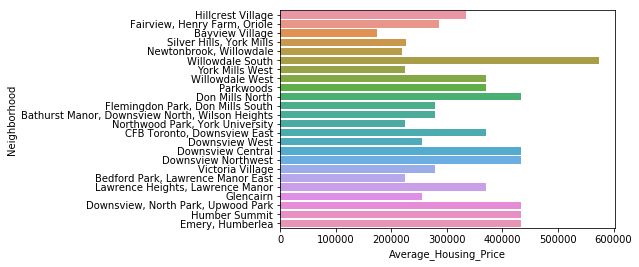

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(data=NorthYork_Avg_HousingPrice, y='Neighborhood',x='Average_Housing_Price',orient='h')

In [51]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [52]:
new_NorthYork=NorthYork_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
NorthYork_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,7,9,5,8,10,10,7]})

In [53]:
NorthYork_school_ratings

,Neighborhood,Top School Rating
0,Hillcrest Village,7
1,"Fairview, Henry Farm, Oriole",9
2,Bayview Village,5
3,"Silver Hills, York Mills",8
4,"Newtonbrook, Willowdale",10
5,Willowdale South,10
6,York Mills West,7
7,Willowdale West,10
8,Parkwoods,1
9,Don Mills North,2


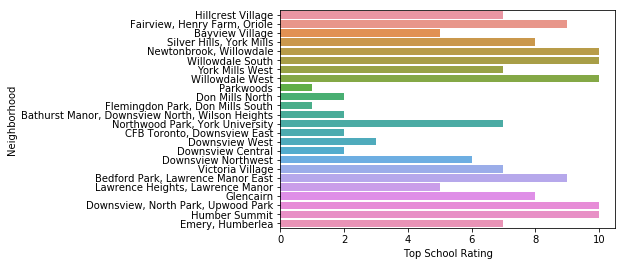

In [54]:
sns.barplot(data=NorthYork_school_ratings, y='Neighborhood',x='Top School Rating')

From the visuals,it is clear that which town has the most school ratings and also the housing prices. So based on that decision can be made according to personal preferences